<a href="https://colab.research.google.com/github/EmmanuelABonsu/CE888/blob/main/src/lab4-recommender/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

In [133]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv", delimiter = ",", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [134]:
# Replacing 99 with Nan
df = df.replace(99, np.NaN)
print(df.shape)
df.head()

(24983, 101)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74.0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [135]:
# Dropping the first column (Corresponding to the total number of jokes)
df = df.drop(0, axis=1)
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [136]:
# Worst Rated Joke
df.mean(axis = 0, skipna = True).idxmin()

58

In [137]:
# # Worst Rated Joke Mean Rating
min(df.mean(axis = 0, skipna = True))

-3.8338796373689923

In [138]:
# Best Rated joke
df.mean(axis = 0, skipna = True).idxmax()

50

In [139]:
# Best Rated Jokes
max(df.mean(axis = 0, skipna = True))

3.6650848950824937

In [140]:
# Convert dataframe to numpy array
arr = df.values
arr

array([[-7.82,  8.79, -9.66, ...,   nan,   nan,   nan],
       [ 4.08, -0.29,  6.36, ...,  0.34, -4.32,  1.07],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [ 2.43,  2.67, -3.98, ...,   nan,   nan,   nan]])

In [141]:
# Check Shape
arr.shape

(24983, 100)

In [179]:
# User 10168 Rating of joke 26
arr[9146][63]

1.75

In [143]:
rated = np.where(~np.isnan(arr))


In [144]:
print(len(rated[0]), rated[1].shape)

1810455 (1810455,)


In [145]:
# Modifying Helper Function
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  new_data = orig.copy()
  rated = np.where(~np.isnan(new_data))
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])


In [146]:
new_arr, idx = replace(arr, 0.1)
new_arr

array([[-7.82,  8.79, -9.66, ...,   nan,   nan,   nan],
       [ 4.08, -0.29,  6.36, ...,  0.34, -4.32,  1.07],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [ 2.43,  2.67, -3.98, ...,   nan,   nan,   nan]])

In [147]:
n_latent_factors = 2
# Initialise as random values
latent_user_preferences = np.random.random((new_arr.shape[0], n_latent_factors))
latent_item_features = np.random.random((new_arr.shape[1], n_latent_factors))

In [148]:
def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err

In [149]:
def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = new_arr[user_id, item_id]
                if not np.isnan(rating) and rating != 99:
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 1) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [150]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)

In [151]:
num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations


Iteration 0/10:	MSE=26.267666
Iteration 1/10:	MSE=25.294656
Iteration 2/10:	MSE=25.008206
Iteration 3/10:	MSE=24.791594
Iteration 4/10:	MSE=24.581297
Iteration 5/10:	MSE=24.369116
Iteration 6/10:	MSE=24.154362
Iteration 7/10:	MSE=23.937880
Iteration 8/10:	MSE=23.720951
Iteration 9/10:	MSE=23.504995


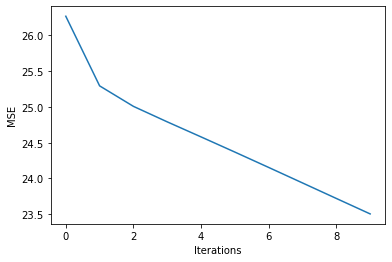

In [152]:
plt.figure()
plt.plot(np.arange(0, num_iter, 1), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [153]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[1.49314696, 1.08294203, 0.93354357, ..., 1.82216235, 0.69082691,
        2.31946381],
       [1.53629678, 1.00799263, 0.92524442, ..., 1.75543867, 0.64686919,
        2.2936282 ],
       [1.99809616, 1.42000737, 1.23956457, ..., 2.40560991, 0.90690431,
        3.07836591],
       ...,
       [1.22961958, 0.67532213, 0.69689856, ..., 1.25730853, 0.43865197,
        1.72087256],
       [0.73427014, 0.66081326, 0.50166842, ..., 1.04019178, 0.41689136,
        1.25273211],
       [1.73105186, 1.22425656, 1.07191604, ..., 2.07739605, 0.78210668,
        2.66172808]])

In [154]:
values = [zip(new_arr[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = df.columns

In [158]:
# Loading Movies Dataset
df_Items = pd.read_excel("movies_latent_factors.xlsx", sheet_name='Items')
df_Items.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


In [185]:
# Highest Factor 10 
id = df_Items['Factor10'].argmax()
# df_Items['Movie ID'] == id

0     False
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: Movie ID, Length: 100, dtype: bool

In [187]:
df_Items.head(id + 1)

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,752,V for Vendetta (2006),-0.642504,0.432674,0.322241,-0.335012,0.230943,-0.618309,0.335841,-0.954064,-0.932023,0.735602,-0.129665,-1.126355,2.014107,-0.279514,1.460253
62,786,Almost Famous (2000),0.640685,1.199326,0.270392,0.371095,0.479752,-0.144391,-0.752597,-0.563700,0.439893,0.267137,-0.242001,0.033085,-0.309858,0.005433,0.256299
63,788,Mrs. Doubtfire (1993),1.952558,0.314091,-1.029966,1.004276,0.853951,0.671413,-0.192968,0.048769,0.399648,0.905301,0.309326,0.335412,0.276849,-0.517637,0.280978
64,807,Seven (a.k.a. Se7en) (1995),-1.261114,1.419946,-0.118211,-0.479119,0.205107,-0.416039,0.205585,-0.697883,-0.360988,-0.246101,0.407891,0.276333,0.741695,-0.597342,0.179386


In [159]:
df_Users = pd.read_excel("movies_latent_factors.xlsx", sheet_name='Users')
df_Users.head()

,User,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
1,156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
2,5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
3,174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4,4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669


In [191]:
# Making Predictions 
user_factors= df_Users[(df_Users["User"] == 4327)]
user_factors = user_factors.drop('User', axis=1)
user_factors

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
21,0.008227,0.073899,-0.323967,0.131203,-0.320862,0.054997,0.060751,0.162314,0.044612,-0.232241,0.094986,-0.10657,-0.051692,-0.09349,0.029534


In [192]:
movie_factors = df_Items[(df_Items["Movie ID"] == 275)]
movie_factors = movie_factors.drop(["Movie ID", "Title"], axis=1)
movie_factors

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
32,-0.623315,1.777301,0.338829,0.219169,-0.084327,-0.138034,-0.656508,-0.368687,0.634641,-0.452721,-0.119612,0.174561,-0.830942,0.239936,0.00343


In [193]:
user_factors.values.dot(movie_factors.values.T)

array([[0.08904923]])

In [196]:
#  Finding top movie recommendations for user 
user_factors= df_Users[(df_Users["User"] == 3806)]
user_factors = user_factors.drop('User', axis=1)
user_factors

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
12,-0.042344,-0.040755,-0.05572,-0.073726,0.018203,0.09194,0.123959,-0.157403,-0.020388,0.082493,0.223057,-0.040915,-0.130308,-0.021816,0.034549


In [197]:
movie_ids = [604, 6033, 13, 43, 854, 77, 4]
ratings = {}
for id in movie_ids:
  movie_factors = df_Items[(df_Items["Movie ID"] == id)]
  movie_factors = movie_factors.drop(["Movie ID", "Title"], axis=1)
  ratings[id] = user_factors.values.dot(movie_factors.values.T)
ratings

{4: array([], shape=(1, 0), dtype=float64),
 13: array([[0.23618354]]),
 43: array([], shape=(1, 0), dtype=float64),
 77: array([[0.16985378]]),
 604: array([[0.74158809]]),
 854: array([[0.87210722]]),
 6033: array([], shape=(1, 0), dtype=float64)}